In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

In [20]:
# Define paths
train_dir = '/kaggle/input/guava-fruit-disease-dataset/Guava Fruit Disease Dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/train'
test_dir = '/kaggle/input/guava-fruit-disease-dataset/Guava Fruit Disease Dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/test'
val_dir = '/kaggle/input/guava-fruit-disease-dataset/Guava Fruit Disease Dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val'


In [21]:
# Image dimensions
img_height = 224
img_width = 224
batch_size = 32  # Define batch size

In [22]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


In [23]:
# Define a custom CNN block with fusion of DenseNet and Residual connections
def custom_cnn_block(x, filters):
    input_tensor = x
    # DenseNet-like block
    x1 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    x1 = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x1)
    
    x2 = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    x2 = layers.Conv2D(filters, (5,5), padding='same', activation='relu')(x2)
    
    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)  # Bottleneck layer
    
    # Residual connection
    shortcut = layers.Conv2D(filters, (1,1), padding='same')(input_tensor)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the model using Functional API
inputs = layers.Input(shape=(img_height, img_width, 3))

# Initial layers
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = inputs
# # Custom CNN blocks with increasing filters
x = custom_cnn_block(x, 64)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = custom_cnn_block(x, 128)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = custom_cnn_block(x, 256)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
# Output layer
outputs = layers.Dense(3, activation='softmax')(x)


In [24]:
# Compile the model
model = models.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 224, 224,  │        256 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 224, 224,  │        256 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 224, 224,  │    102,464 │ conv2d_44[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 224, 224,  │          0 │ conv2d_43[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 224, 224,  │      8,256 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 224, 224,  │        256 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 224, 224,  │          0 │ conv2d_46[0][0],  │
│                     │ 64)               │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 224, 224,  │          0 │ add_6[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 112, 112,  │      8,320 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 112, 112,  │      8,320 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_48[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 112, 112,  │    409,728 │ conv2d_50[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 112, 112,  │          0 │ conv2d_49[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 112, 112,  │     32,896 │ concatenate_7[0]

 Total params: 3,321,795 (12.67 MB)

 Trainable params: 3,321,795 (12.67 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_wn2.keras', save_best_only=True, monitor='val_loss')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)


In [31]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - accuracy: 0.9760 - loss: 0.0613 - val_accuracy: 0.9775 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 359ms/step - accuracy: 0.9738 - loss: 0.0638 - val_accuracy: 0.9722 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - accuracy: 0.9728 - loss: 0.0756 - val_accuracy: 0.9709 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 360ms/step - accuracy: 0.9778 - loss: 0.0649 - val_accuracy: 0.9497 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 0.9738 - loss: 0.0687 - val_accuracy: 0.9523 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 357ms/step - accuracy: 0.9799 - loss: 0.0602 - val_accuracy: 0.9762 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - accuracy: 0.9816 - loss: 0.

In [32]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.9971 - loss: 0.0106
Test Accuracy: 0.9948


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step
Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.99      1.00      1.00       156
    fruit_fly       1.00      0.98      0.99       132
healthy_guava       0.99      1.00      0.99        94

     accuracy                           0.99       382
    macro avg       0.99      0.99      0.99       382
 weighted avg       0.99      0.99      0.99       382



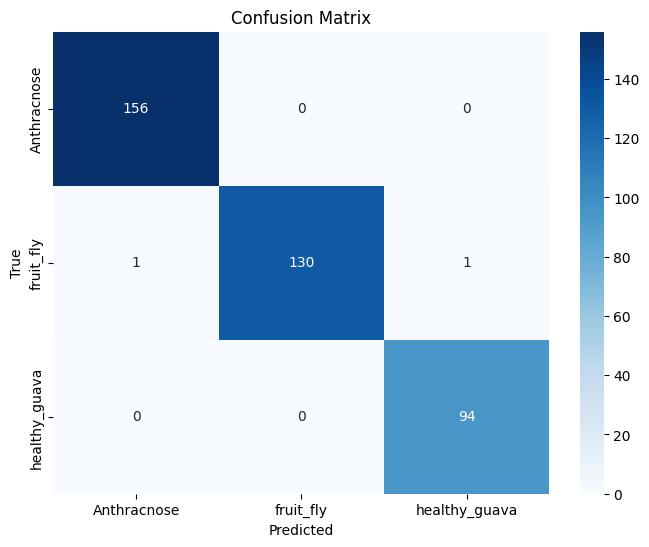

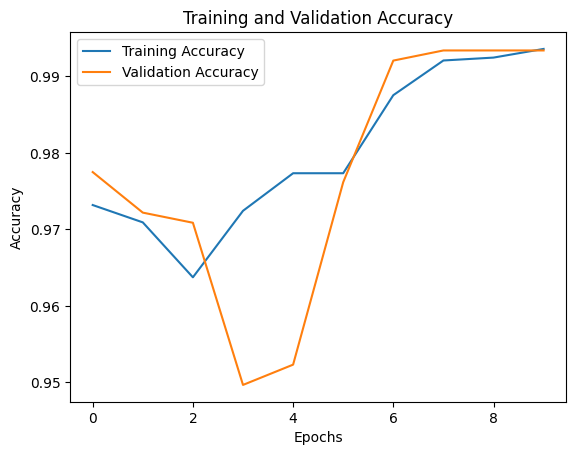

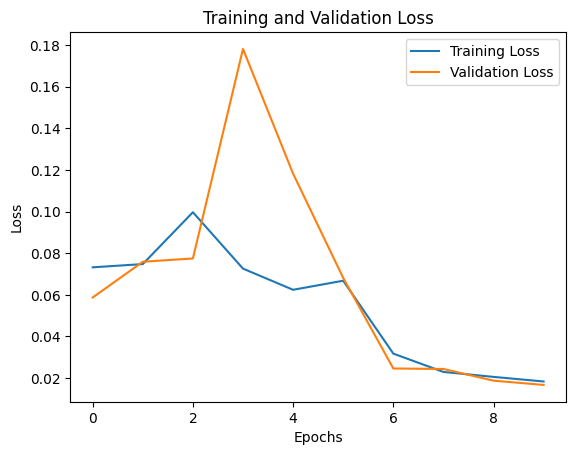

In [33]:
# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Classification report
print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


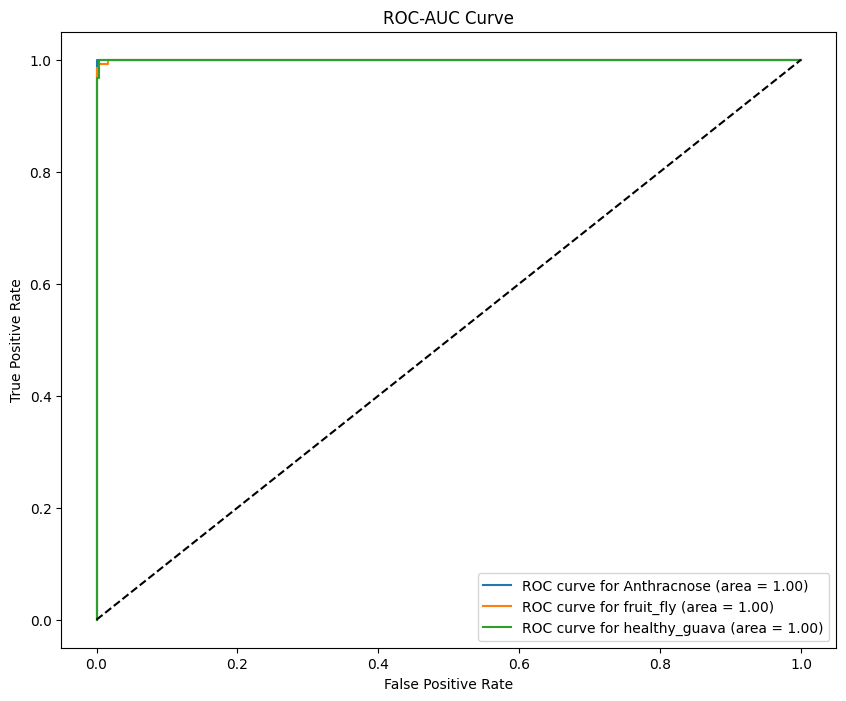

In [34]:
# ROC-AUC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i, class_name in enumerate(test_generator.class_indices.keys()):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_name} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


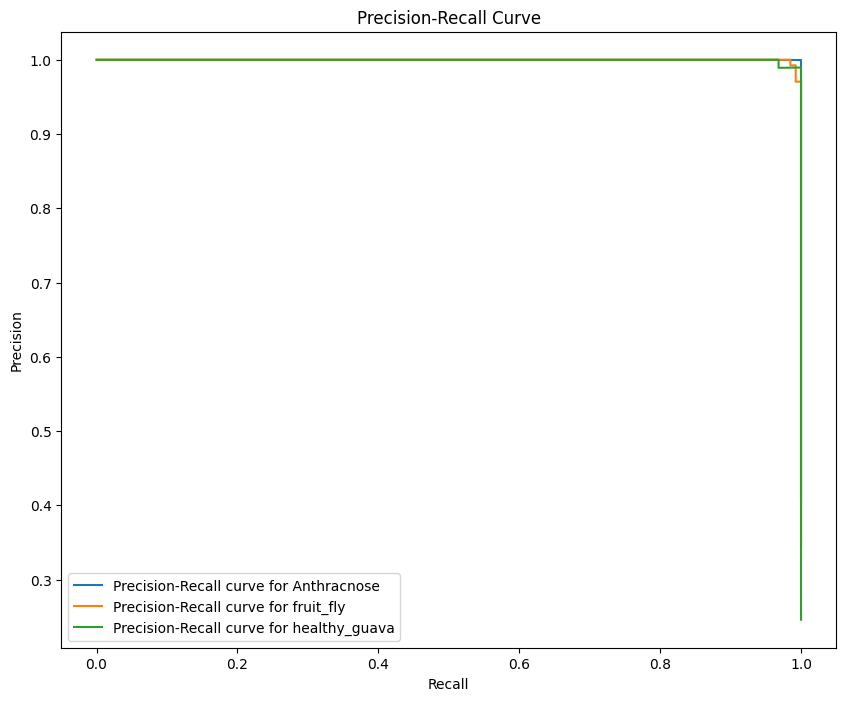

In [35]:
# Precision-Recall Curve
precision = {}
recall = {}
for i, class_name in enumerate(test_generator.class_indices.keys()):
    precision[i], recall[i], _ = precision_recall_curve(true_classes == i, predictions[:, i])

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_generator.class_indices.keys()):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve for {class_name}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()